In [122]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [132]:
# Fuzzy controller based off of example here: 
# https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html#example-plot-tipping-problem-newapi-py

# input current speed and distance
curr_speed = int(input("current speed:"))
dist = int(input("distance:"))

# calculate the 3 second distance based off current speed
safe_dist = (curr_speed / 3.6) * 3

# New Antecedent/Consequent objects hold universe variables and membership functions
distance = ctrl.Antecedent(np.arange(0, safe_dist * 2, 1), 'distance')
current_speed = ctrl.Antecedent(np.arange(0, curr_speed * 2, 1), 'current_speed')
adjust_speed = ctrl.Consequent(np.arange(-100, 100.01, 1), 'adjust_speed')

C:\Users\Beau\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Beau\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Beau\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


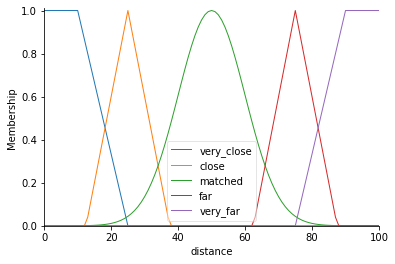

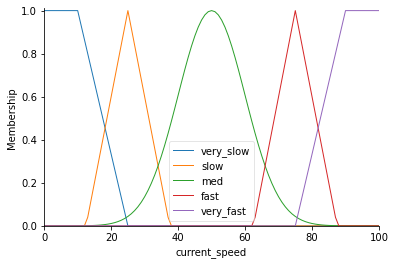

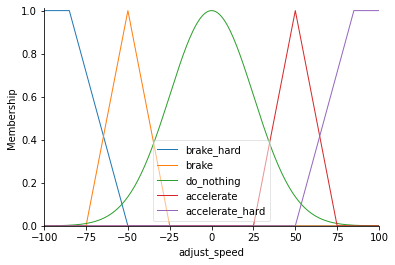

In [124]:
# membership functions
distance['very_close'] = fuzz.trapmf(distance.universe, [0, 0, safe_dist * 0.1, safe_dist * 0.25])
distance['close'] = fuzz.trimf(distance.universe, [safe_dist * 0.125, safe_dist * 0.25, safe_dist * 0.375])
distance['matched'] = fuzz.gaussmf(distance.universe, safe_dist, 10)
distance['far'] = fuzz.trimf(distance.universe, [safe_dist * 1.625, safe_dist * 1.75, safe_dist * 1.875])
distance['very_far'] = fuzz.trapmf(distance.universe, [safe_dist * 1.75, safe_dist * 1.9, safe_dist * 2, safe_dist * 1.2])

current_speed['very_slow'] = fuzz.trapmf(current_speed.universe, [0, 0, curr_speed * 0.1, curr_speed * 0.25])
current_speed['slow'] = fuzz.trimf(current_speed.universe, [curr_speed * 0.125, 25, 37.5])
current_speed['med'] = fuzz.gaussmf(current_speed.universe, 50, 10)
current_speed['fast'] = fuzz.trimf(current_speed.universe, [62.5, 75, 87.5])
current_speed['very_fast'] = fuzz.trapmf(current_speed.universe, [75, 90, 100, 100])

adjust_speed['brake_hard'] = fuzz.trapmf(adjust_speed.universe, [-100, -100, -85, -50])
adjust_speed['brake'] = fuzz.trimf(adjust_speed.universe, [-75, -50, -25])
adjust_speed['do_nothing'] = fuzz.gaussmf(adjust_speed.universe, 0, 25)
adjust_speed['accelerate'] = fuzz.trimf(adjust_speed.universe, [25, 50, 75])
adjust_speed['accelerate_hard'] = fuzz.trapmf(adjust_speed.universe, [50, 85, 100, 100])

# Visualise membership functions
distance.view()
current_speed.view()
adjust_speed.view()

In [125]:
# Define Rules

# Very close
veryclose = ctrl.Rule(distance['very_close'], adjust_speed['brake_hard'])

# Close
close_veryslow = ctrl.Rule(distance['close'] & current_speed['very_slow'], adjust_speed['brake'])
close_slow = ctrl.Rule(distance['close'] & current_speed['slow'], adjust_speed['brake'])
close_med = ctrl.Rule(distance['close'] & current_speed['med'], adjust_speed['brake'])
close_fast = ctrl.Rule(distance['close'] & current_speed['fast'], adjust_speed['brake_hard'])
close_veryfast = ctrl.Rule(distance['close'] & current_speed['very_fast'], adjust_speed['brake'])

# Distance matched
matched_veryslow = ctrl.Rule(distance['matched'] & current_speed['very_slow'], adjust_speed['do_nothing'])
matched_slow = ctrl.Rule(distance['matched'] & current_speed['slow'], adjust_speed['do_nothing'])
matched_med = ctrl.Rule(distance['matched'] & current_speed['med'], adjust_speed['do_nothing'])
matched_fast = ctrl.Rule(distance['matched'] & current_speed['fast'], adjust_speed['brake'])
matched_veryfast = ctrl.Rule(distance['matched'] & current_speed['very_fast'], adjust_speed['brake'])

# Far
far_veryslow = ctrl.Rule(distance['far'] & current_speed['very_slow'], adjust_speed['accelerate_hard'])
far_slow = ctrl.Rule(distance['far'] & current_speed['slow'], adjust_speed['accelerate_hard'])
far_med = ctrl.Rule(distance['far'] & current_speed['med'], adjust_speed['accelerate'])
far_fast = ctrl.Rule(distance['far'] & current_speed['fast'], adjust_speed['do_nothing'])
far_veryfast = ctrl.Rule(distance['far'] & current_speed['very_fast'], adjust_speed['brake'])

# Very far
veryfar_veryslow = ctrl.Rule(distance['very_far'] & current_speed['very_slow'], adjust_speed['accelerate_hard'])
veryfar_slow = ctrl.Rule(distance['very_far'] & current_speed['slow'], adjust_speed['accelerate_hard'])
veryfar_med = ctrl.Rule(distance['very_far'] & current_speed['med'], adjust_speed['accelerate'])
veryfar_fast = ctrl.Rule(distance['very_far'] & current_speed['fast'], adjust_speed['do_nothing'] )
veryfar_veryfast = ctrl.Rule(distance['very_far'] & current_speed['very_fast'], adjust_speed['brake'] )



In [126]:
# Create control system
dist_ctrl = ctrl.ControlSystem([veryclose, 
                                close_veryslow, close_med, close_fast, close_veryfast, 
                                matched_veryslow, matched_slow, matched_med, matched_fast, matched_veryfast,
                                far_veryslow, far_slow, far_med, far_fast, far_veryfast,
                                veryfar_veryslow, veryfar_slow, veryfar_med, veryfar_fast ])

In [127]:
# Simulate control system
fuzzctrl = ctrl.ControlSystemSimulation(dist_ctrl)

In [128]:
# Provide inputs to distance and current speed - compute to obtain result
# dist = int(input("distance:"))
# curr_speed = int(input("current speed:"))

fuzzctrl.input['distance'] = int(dist)
fuzzctrl.input['current_speed'] = int(curr_speed)

fuzzctrl.compute()

current speed:		 25
distance:		 75
speed adjustment:	 69.04


C:\Users\Beau\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Beau\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Beau\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


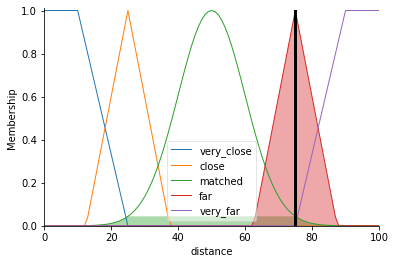

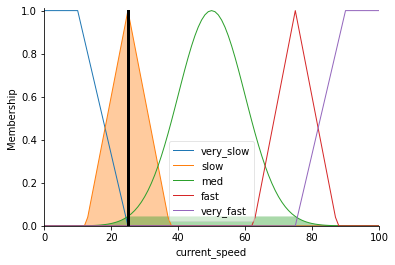

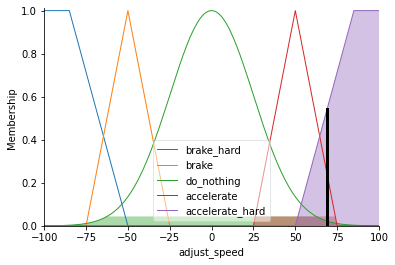

In [129]:
# Print result and visualise
print("current speed:\t\t", curr_speed)
print("distance:\t\t", dist)
print("speed adjustment:\t", round(fuzzctrl.output['adjust_speed'], 2))

distance.view(sim=fuzzctrl)
current_speed.view(sim=fuzzctrl)
adjust_speed.view(sim=fuzzctrl)